### Student Activity: Financial Forecasting Part I

This program executes a single simulation of stock price trajectory over the next `252 * 3` trading days (or 3 years of trading) for `TSLA` stock, based on a normal probability distribution of historical daily returns derived from the sample mean and standard deviation.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()


# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'id': '2ad15d25-a851-44c9-891f-d19e54a905d5',
     'marginable': True,
     'name': 'Arbor Realty Trust, Inc 8.250% Series A Cumulative Redeemable '
             'Preferred Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'ABR-A',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'id': 'b769adcd-7514-4e56-85ee-dabc29e801e4',
     'marginable': True,
     'name': 'Arbor Realty Trust, Inc. 7.75% Series B Preferred',
     'shortable': False,
     'status': 'active',
     'symbol': 'ABR-B',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'add2d2c9-fce7-4155-a232-5ae7470e7178',
     'marginable': True,
     'name': 'Arch Capital Group Ltd. Depositary Shares Each Representing '
             '1/1,000th Interest in a Share of 5.45% Non

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,ABILF
1,ABR-A
2,ABR-B
3,ACGLO
4,ACIA
5,KTP
6,ACIO
7,LVHE
8,ACIU
9,ACLS


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "TSLA"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Format end_date and start_date with isoformat
end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()


# Get 1 year's worth of historical data for TSLA
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

TSLA                                       
                             open      high       low    close    volume
2019-05-31 00:00:00-04:00  185.10  189.9204  184.1000  185.480   9599948
2019-06-03 00:00:00-04:00  185.51  186.6800  176.9919  179.010  12380263
2019-06-04 00:00:00-04:00  181.10  193.9800  179.6100  193.910  13115692
2019-06-05 00:00:00-04:00  198.47  201.2782  191.8486  196.677  12570739
2019-06-06 00:00:00-04:00  204.25  211.0000  201.8000  206.080  19472101

### Drop Extraneous Levels and Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-05-31,185.480
2019-06-03,179.010
2019-06-04,193.910
2019-06-05,196.677
2019-06-06,206.080


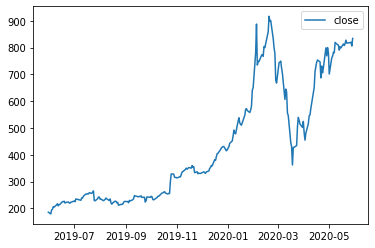

In [16]:
df.plot()

### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of TSLA
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-05-31,NaN
2019-06-03,-0.034882
2019-06-04,0.083236
2019-06-05,0.014270
2019-06-06,0.047809


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for TSLA
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.007164291903814196

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for TSLA
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.048150183526183984

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [17]:
# Set number of trading days and get last closing price of TSLA from DataFrame
num_trading_days = 252 * 3
tsla_last_price = df['close'][-1]

# Initialize the simulated prices list with the last closing price of TSLA
simulated_tsla_prices = [tsla_last_price]

# Simulate the returns for 252 * 3 trading days
for i in range(num_trading_days):
    # Calculate the simulated price using the last price within the list
    simulated_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
    # Append the simulated price to the list
    simulated_tsla_prices.append(simulated_price)
    
# Create a DataFrame of the simulated prices
simulated_price_df = pd.DataFrame({
    "Simulated TSLA Prices": simulated_tsla_prices})

# Print head of DataFrame
simulated_price_df.head()

,Simulated TSLA Prices
0,834.190500
1,867.907267
2,803.286898
3,803.809804
4,756.820477


### Plot the Simulated Stock Price Trajectory for TSLA over the Next 3 Years (252 * 3) of Trading Days

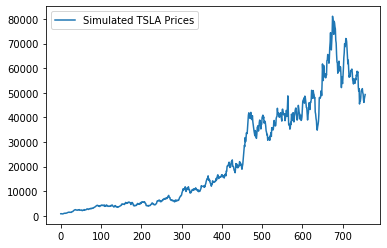

In [18]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a (252 * 3) trading day simulation
simulated_price_df.plot()

### Calculate Daily Returns of Simulated Stock Prices for TSLA

In [19]:
# Use the `pct_change` function to calculate daily returns of simulated stock prices for TSLA
simulated_daily_returns = simulated_price_df.pct_change()
simulated_daily_returns.head()

,Simulated TSLA Prices
0,NaN
1,0.040419
2,-0.074455
3,0.000651
4,-0.058458


### Calculate the Cumulative Returns of Simulated Stock Prices for TSLA

In [20]:
# Use the `cumprod` function to calculate the cumulative returns of simulated stock prices for TSLA
simulated_cumulative_returns = (1 + simulated_daily_returns).cumprod()
simulated_cumulative_returns.head()

,Simulated TSLA Prices
0,NaN
1,1.040419
2,0.962954
3,0.963581
4,0.907251


### Calculate the Cumulative Profits/Losses of Simulated Stock Prices for TSLA

In [21]:
# Multiply an initial investment by the cumulative returns of simulative stock prices to
# return the progression of cumulative returns in terms of money
initial_investment = 10000
cumulative_pnl = initial_investment * simulated_cumulative_returns
cumulative_pnl.head()

,Simulated TSLA Prices
0,NaN
1,10404.185463
2,9629.537827
3,9635.806256
4,9072.513732


### Plot the Cumulative Profits/Losses of `$10,000` in TSLA Over the Next 3 Years (252 * 3) of Trading Days

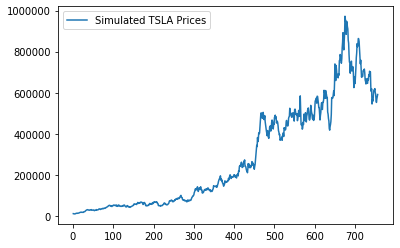

In [22]:
# Use the 'plot' function to create a chart of the cumulative profits/losses
cumulative_pnl.plot()